<a href="https://colab.research.google.com/github/lw-miles24/12-CompModNervSys-ExtracellularStim/blob/main/CompModNervSys_exercise12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOL 74.03 (SP23): Computational Modeling of the Nervous System
# Exercise 12: Modeling electrical stimulation of axons

### Exercise goals

1) Visualize spatial distribution of activating function for point source electrical stimulation

2) Understand difference between polarization generated by intracelullar vs. extracellular stimulation

3) Understand effect of diameter, electrode distance, and pulse width on activation threshold

Work through the code below, running each cell, adding code where required, and making sure you understand the output. When you see questions with <span style="color:red">***Q:*** </span> preceding them, write your responses in text cells. Numbered items (<font color='red'>1, 2, etc. </font>) indicate instructions for code you need to write.


We'll be using NEURON for this exercise, so we first install neuron to our runtime.

In [1]:
%pip install neuron # only need to run this cell once to install
                    # neuron in the local jupyter environment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 28.5 MB/s eta 0:00:00


Run the code block below just once to get all the files we need from the repository into our colab session and to compile the MOD mechanism files we'll be using.

In [2]:
repo_name = 'CompModNervSys-ExtracellularStim'
if 'google.colab' in str(get_ipython()): # Running on colab
    import os
    # from distutils.dir_util import copy_tree
    if not os.path.exists(repo_name):
        !git clone https://github.com/CompModNervSystem/{repo_name}.git # downloads repository into our Google colab session's file system

    os.chdir('/content/' + repo_name)

# Compile mechanisms
!nrnivmodl mechanisms

Cloning into 'CompModNervSys-ExtracellularStim'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 13 (delta 3), reused 13 (delta 3), pack-reused 0
Receiving objects: 100% (13/13), 13.14 KiB | 1.46 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/CompModNervSys-ExtracellularStim
Mod files: "mechanisms/mechanisms/xtra.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../mechanisms/xtra.mod
Translating xtra.mod into /content/CompModNervSys-ExtracellularStim/x86_64/xtra.c
Notice: Use of POINTER is not thread safe.
 -> Compiling xtra.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special


Now we can import the packages we'll be using

In [3]:
from neuron import h # all NEURON hoc functions are accessed through h
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library
import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import matplotlib.pyplot as plt

# Visualizing the activating function for a point current source

In our previous NEURON simulations, we simulated cable models while assuming the extracellular potential was uniformly zero. Incorporating an imposed extracellular potential distribution gives the following form of the continuous cable equation for a passive membrane model:

$ \tau_{m}\frac{\partial V_{m}}{\partial t} +  (V_{m} - E_{rev}) + \lambda^{2}\frac{\partial^2 V_{m}}{\partial x^2} = \lambda^{2}\frac{\partial^2 V_{e}}{\partial x^2} $.

Here, $V_{m}$ is the membrane potential, the intracellular potential $V_{i}$ minus the extracellular potential $V_{e}$, $\tau_{m}$ is the membrane time constant ($r_{m}c_{m}$), $E_{rev}$ is the reversal potential, and $\lambda$ is the length constant ($\sqrt \frac{r_{m}}{r_{a}}$).

The term on the right hand side is known as the *activating function*. It tells us the *initial rate of change* of the membrane potential at position $x$ is proportional to local length constant and the second derivative of the extracellular potential along the axon. Recall, since the electric field is given by the negative gradient of the electric potential, the second derivative term can also be expressed as the first derivative of the electric field component aligned with the axon.

It's important to remember the activating function does not tell us directly the total change in voltage in the neuron, since this will depend on the morphology, membrane conductances, and stimulus waveform. Still, it's a good way to gain some intuition and rough approximation of how specific electric field distributions affect a neuron's membrane potential.

Numerically, this second derivative is given by the *second difference*, allowing us to calculate the activating function $f_{a}$ with:

$ f_{a} = \lambda^{2} \cdot V_{e}(n-1) - 2V_{e}(n) + V_{e}(n+1)$,

where $n$ refers to the segment index.

Let's simulate the activating function for a passive, straight, unmyelinated axon. The `ExtraAxon.py` file defines a class called `Axon` that generates an unmyelinated axon and implements a number of useful methods for simulating extracellular stimulation in NEURON. For now, we'll just use it to instantiate an axon model and generate coordinates for us to calculate the activating function ourselves.

The code block below generates a $1 \; \mu m$ diameter, $6 \; mm$ long unmyelinated axon with specific membrane capacitance `cm` of $1 \; \mu F/cm^{2}$, specific membrane conductance `g_pas` of $5 \cdot 10^{-4} S/cm^{2}$, and axial resistance `Ra` set to $100 \; \Omega cm$. We'll use a reversal potential (`e_pas`) of $0 \; mV$ to focus on quantifying polarization (i.e., change in membrane potential).

In [4]:
from ExtraAxon import Axon

diam = 1 # diameter - µm
L = 6e3 # length - µm
uaxon = Axon(0,diam,L)

### Point current source

We'll start by simulating by the activating function generated by a point current source positioned above an axon. This approximates a variety of scenarios, including stimulation of long axon collaterals in cerebral cortex or stimulation of unmyelinated axons in peripheral or spinal cord tracts with implanted microelectrodes.

For most neural stimulation and recording contexts, we can use something called the *quasistatic* assumption, which basically means we can ignore time-dependent effects of electromagnetic current flow in tissue. One benefit of this assumption is we can separate out the spatial and temporal component of the extracellular electric field. So, the extracellular potential at a point $(x,y,z)$ and time $t$ is:

$V_{e}(x,y,z,t) = V_{e}(x,y,z)\cdot I(t)$.

Here, $I(t)$ is the stimulus waveform. In other words, the total potential at any point in time is just a linear scaling of the spatial distribution of potentials by some stimulus waveform.

The extracellular potential distribution generated by a point current source at a given point in space $(x,y,z)$ is given by

$V_{e}(x,y,z) = \frac{I}{4 \pi \sigma_{e} r} $,

where $I$ is the current amplitude, $\sigma_{e}$ is the extracellular conductivity, and $r$ is the distance from the electrode.

Let's start by computing the extracellular potential distribution along the axon for an electrode positioned above the *center* of the axon and $0.1 \; mm$ away ($y = 0.1 \; mm$).

The coordinates of the axon model can be accessed using `uaxon.coords`. This variable is an $N \times 3$ `numpy` array, where $N$ is the number of segments and each row is the position $(x, y, z)$ of the corresponding segment. By default, the axon is positioned at $y=z=0$, so we only have to worry about variations in the $x$ direction. Remember the units of length in NEURON are $\mu m$ ($ 1 \; mm = 1000 \; \mu m$).

<font color='red'> 1. </font> Fill in the code block below to plot the coordinates of the axon's compartments and the electrode position in $mm$.

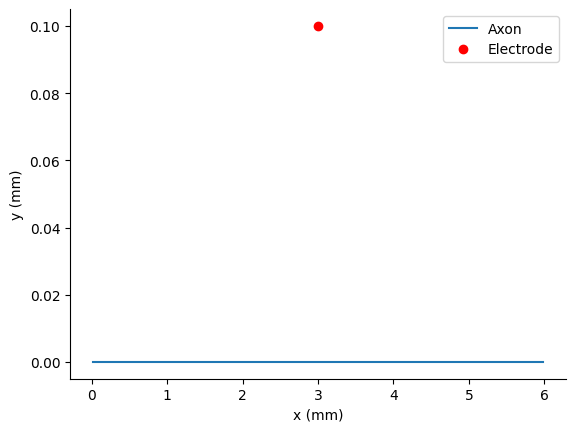

In [14]:
xelec = L/2 # µm - center of axon
yelec = 100 # µm

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(uaxon.coords[:,0]*1e-3,uaxon.coords[:,1]*1e-3,'-',label='Axon')
ax.plot(xelec*1e-3,yelec*1e-3,'ro',label='Electrode');
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.legend();

### Distribution of extracellular potential and activating function

The function `calc_Ve` below calculates the extracellular potential in mV per $\mu A$ current at a set of coordinates for a specific electrode position. We'll use a conductivity $\sigma_{e} = 0.3 \times 10^{-7} \; S/µm$.

In [15]:
def calc_Ve(xe,ye,coords,sigma_e=0.3e-7):
    # Returns extracellular potential in mV per µA current
    # Input arguments:
    #   xe - electrode x position in µm
    #   ye - electrode y position in µm
    #   coords - N x 3 numpy array of [x,y,z] coordinates at which to compute Ve
    #   sigma_e - extracellular conductivity in S/µm
    # Output:
    #   Ve - N x 1 numpy array of extracellular potential values
    #       generated by 1 µA point current source at coords
    re = np.sqrt((xe - coords[:,0])**2 + (ye - coords[:,1])**2) # distance in µm
    # Ve in [mV] for I of 1 [µA] <= µA*1e-3 = mA * 1/(S*µm^-1 * µm) = mV
    Ve = 1e-3/(4*np.pi*sigma_e*re)
    return Ve

<font color='red'> 2. </font> Now, using this function, plot the extracellular potential along the axon with the $x$ position in $mm$ on the x-axis and extracellular potential in $mV$ on the y-axis

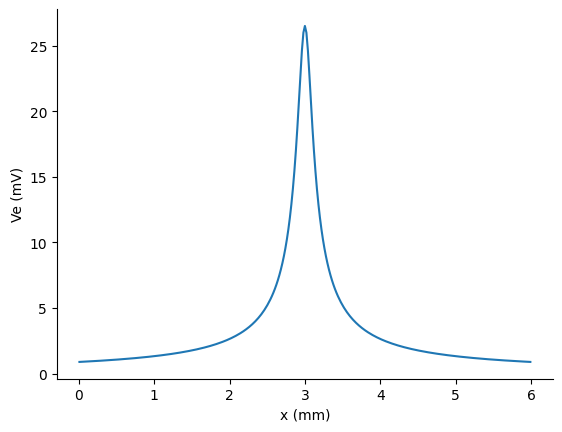

In [17]:
# Calculate potential Ve

Ve = calc_Ve(xelec,yelec,uaxon.coords)
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(uaxon.coords[:,0]*1e-3,Ve)
ax.set_xlabel('x (mm)')
ax.set_ylabel('Ve (mV)');

You should see a symmetric, sharply peaked curve with the max extracellular potential just above center of the axon.

<font color='red'> 3. </font> Below, calculate the first and second difference of `Ve` using [`numpy.diff`](https://numpy.org/doc/stable/reference/generated/numpy.diff.html), setting the order `n` to 1 and 2, respectively. Then, overlay on the same plot the extracellular potential and first and second differences, dividing each vector by the max of the absolute value so you can compare their distributions.

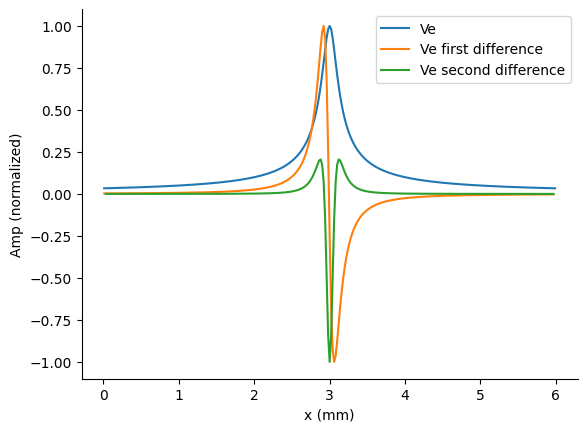

In [26]:
# Your code goes here
Vediff1 = np.diff(Ve,1) # call np.diff on Ve to compute 1st difference
Vediff2 = np.diff(Ve,2) # call np.diff on Ve to compute 2nd difference

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(uaxon.coords[:,0]*1e-3,Ve/np.max(np.abs(Ve)),label='Ve')
ax.plot(uaxon.coords[:-1,0]*1e-3,Vediff1/np.max(np.abs(Vediff1)),label='Ve first difference')
ax.plot(uaxon.coords[1:-1,0]*1e-3,Vediff2/np.max(np.abs(Vediff2)),label='Ve second difference')
# Plot normalized 1st and 2nd difference here
# make sure to index uaxon.coords appropriately since there taking the 1st difference reults
# in 1 fewer elements in the vector, and the 2nd difference results in 2 fewer elements

ax.set_xlabel('x (mm)')
ax.set_ylabel('Amp (normalized)')
ax.legend();


<font color='red'>**Q1**:
Where do you expect maximal depolarization and hyperpolarization to occur for this configuration, i.e. at how many locations and approximately what $x$ position/s?
</font>

The second derivative constitutes the activating function, which tells us how the neuron will polarize in response to the electrode. It seems like we can expect maximal depolarization at x = 3: just under the electrode, the second derivative is most negative, producing the strongest negative/inward/depolarizing current. We'd get maximal hyperpolarizing at x = 2.9/3.1: just slightly away from the electrode in either direction, the second derivative is most positive, producing the strongest positive/outward/hyperpolarizing current.

This distribution corresponds to a positive current, referred to as an *anode*. How does the distribution look if the stimulating electrode delivers negative current, i.e. is a *cathode*?

<font color='red'> 4. </font> Replot your figure above but starting with negative `Ve` to visualize the activating function of a cathode.

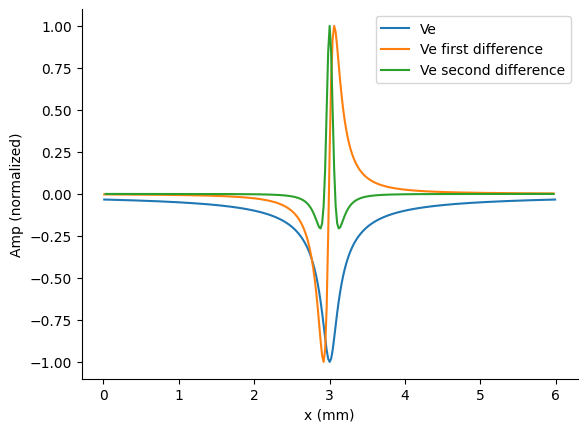

In [27]:
Vecat = -Ve
# Your code goes here
Vediff1 = np.diff(Vecat,1) # call np.diff on Ve to compute 1st difference
Vediff2 = np.diff(Vecat,2) # call np.diff on Ve to compute 2nd difference

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(uaxon.coords[:,0]*1e-3,Vecat/np.max(np.abs(Vecat)),label='Ve')
ax.plot(uaxon.coords[:-1,0]*1e-3,Vediff1/np.max(np.abs(Vediff1)),label='Ve first difference')
ax.plot(uaxon.coords[1:-1,0]*1e-3,Vediff2/np.max(np.abs(Vediff2)),label='Ve second difference')
# Plot normalized 1st and 2nd difference here
# make sure to index uaxon.coords appropriately since there taking the 1st difference reults
# in 1 fewer elements in the vector, and the 2nd difference results in 2 fewer elements

ax.set_xlabel('x (mm)')
ax.set_ylabel('Amp (normalized)')
ax.legend();

<font color='red'>**Q2**:
Just as we asked above, where do you expect maximal depolarization and hyperpolarization to occur for the cathode, i.e. at how many locations and approximately what $x$ position/s? How does this differ from the anodic situation?
</font>

It's the inverse case as the one above: maximal hyperpolarizing at x = 3 and maximal depolarization at x = 2.9/3.1. This all makes sense: the same intensity and position, but different directionality.

# Simulating extracellular stimulation in NEURON

Now that we've gained some intuition for how the extracellular potential distribution generated by a point current source will influence the membrane potential, let's actually run a simulation. We now have a function to calculate the extracellular potentials at each compartment of our neuron model, and the last piece we need is the temporal waveform.

To introduce these extracellular potentials into the model, we'll use a custom "dummy" membrane mechanism called `xtra` to store the extracellular potentials we want to apply in a *range* variable called `es_xtra` and the temporal waveform using a *global* variable called `stim_xtra`. Below, we define a function called `assign_Ve` to assign potentials calculated with `calc_Ve` to `es_xtra` for each segment in our axon.


In [28]:
def assign_Ve(xe,ye,axon):
    # assign potentials to es_xtra (points to e_xtracellular) for point current source
    # Input arguments:
    #   xe - electrode x position in µm
    #   ye - electrode y position in µm
    #   axon - Axon object, contains unmyelinated axon model, defined in ExtrAxon.py
    Ve = calc_Ve(xe,ye,axon.coords)
    for i, seg in enumerate(axon.axon):
        seg.es_xtra = Ve[i] # mV/µA
    return Ve

For the temporal waveform of the current stimulus, the `set_waveform` function below generates a rectangular pulse and links it to the `stim_xtra` variable to ensure the spatial distribution of voltages is scaled over time during the simulation.

In [29]:
def set_waveform(delay,duration,amp):
    # Generate monophasic, rectangular waveform and assign to stim_xtra
    # Input arguments:
    #   delay - time to start of stimulus (ms)
    #   duration - pulse width (ms)
    #   amp - amplitude of current pulse (µA)
    stimvec = h.Vector(0)
    tvec = h.Vector(0)
    stimvec.resize(6)
    stimvec.fill(0)
    stimvec.x[2] = amp
    stimvec.x[3] = amp
    tvec.resize(6)
    tvec.fill(0)
    tvec.x[1] = delay
    tvec.x[2] = delay
    tvec.x[3] = delay + duration
    tvec.x[4] = delay + duration
    tvec.x[5] = max(h.tstop,delay+duration+1)
    # attach stimulus to is_xtra
    stimvec.play(h._ref_stim_xtra,tvec,1)
    return tvec, stimvec

Now that we have all the pieces, let's run a simulation.

To make things easier, the `run_extracellular_stim` function below wraps setting of the extracellular potentials and the temporal waveform and runs the simulation.

You can access the voltage recordings ($V_{m}$ over time) from each segment of the axon within the `uaxon` object in `uaxon.seg_vs`, which holds a list of vectors.

To get the index of the array corresponding to an arbitrary position along the axon, you can use a helper function `get_closest_index` which whould look familiar from [Exercise 8](https://github.com/CompModNervSystem/CompModNervSys-CableAxon/blob/main/CompModNervSys_exercise8.ipynb). It returns the index of the segment given a normalized position $x$ along the length of the section. The x-value (noramlized position) for each segment is stored in `uaxon.x_vals`.

In [30]:
def run_extracellular_stim(xe,ye,delay,duration,amp,axon):
    # assign potentials
    Ve = assign_Ve(xe,ye,axon)
    # Set temporal waveform
    tstim, stim = set_waveform(delay,duration,amp)
    # Run simulation
    h.run()
    return Ve, tstim, stim

# Define helper function to get index of recording for any position along axon
def get_closest_index(vec,val):
    # finds closest value to x in x_vals vector, outputs index
    # if x>1, outputs index for x = 1, and if x<0, outputs index for x = 0
    return np.argmin(np.abs(vec-val))

<font color='red'>5.</font> Position the electrode $500 \; \mu m$ above the center of the axon (note the changed distance). Apply a $10 \; ms$ long pulse starting at $t = 1 \; ms$ with amplitude $-10 \; \mu A$.

For simulation settings, set the initial voltage to $0 \; mV$ (our reversal potential), time step to $0.01 \; ms$, and duration to $20 \; ms$.

Then, plot the change in voltage over time at the center and at `x = 0.2` and `x = 0.8` (normalized distance along the axon length)

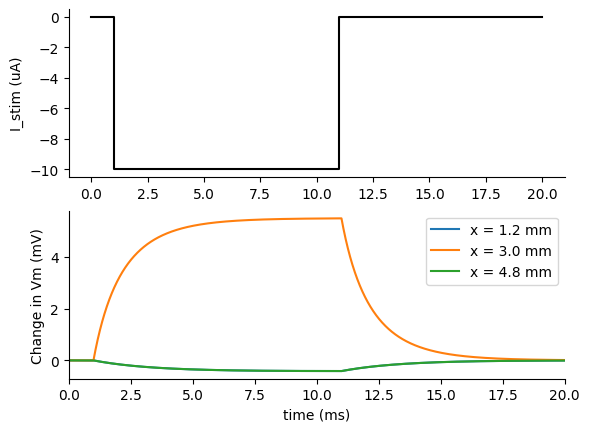

In [51]:
# Define stimulation parameters
# Your code goes here
xelec = L/2 # um
yelec = 500 # um
delay = 1 # ms
duration = 10 # ms
amp = -10 # µA

# Define simulation parameters
h.v_init = 0 # mV
h.steps_per_ms = 1/.01
h.dt = 0.01 # ms
h.tstop = 20 # ms
# Get time vector
t_vec = h.Vector().record(h._ref_t)

# Run simulation
Ve, tstim, stim = run_extracellular_stim(xelec,yelec,delay,duration,amp,uaxon)

# Plot
x_plot = [0.2,0.5,0.8] # normalized along axon length
fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(tstim,stim,'k')
ax.set_ylabel('I_stim (uA)')
ax = fig.add_subplot(212)
for x in x_plot:
    x_index = get_closest_index(uaxon.x_vals,x) # get index of this location along the axon
    # your code goes here
    # Use x_index to extract Vm recording at corresponding x position within axon
    Ve_spec = uaxon.seg_vs[x_index]
    # Plot Vm vs. t at this x
    ax.plot(t_vec,Ve_spec,label='x = {:.1f} mm'.format(x*L*1e-3))

ax.set_xlabel('time (ms)')
ax.set_ylabel('Change in Vm (mV)')
ax.set_xlim(t_vec[0],t_vec[-1])
ax.legend();

Now, let's plot the change in voltage over space. Similar to [Exercise 8](https://github.com/CompModNervSystem/CompModNervSys-CableAxon/blob/main/CompModNervSys_exercise8.ipynb), we'll generate a matrix of voltage recordings (rows are time points, columns are positions $x$ along the axon).

<font color='red'>6.</font> Using this matrix, plot the change in voltage vs. position $x$ at $0.1$, $72$, and $5 \; ms$ after the start of the stimulus (at $t = 5\; ms$).

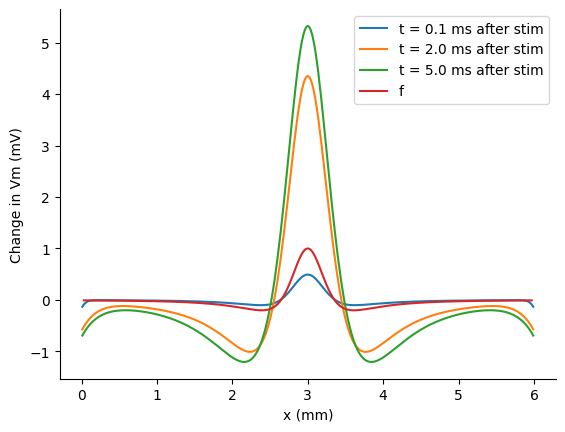

In [63]:
V_vecs_arr = [np.array(v) for v in uaxon.seg_vs]
V_vecs_arr = np.array(V_vecs_arr).T # convert to number of time points x number of segments matrix

# Your code goes here
plot_t_vals = [0.1+delay,2+delay,5+delay] # set time values to plot

fig = plt.figure()
ax = fig.add_subplot(111)
for t in plot_t_vals:
    t_index = get_closest_index(t_vec,t) # index of this time point
    # Index V_vecs_arr to extract Vm vs. x at time t
    Vt = V_vecs_arr[t_index]
    ax.plot(uaxon.coords[:,0]*1e-3,Vt,label=f't = {t-delay:.1f} ms after stim')
# Bonus
Ve2 = np.diff(Ve*amp,n=2)
ax.plot(uaxon.coords[1:-1,0]*1e-3,Ve2/np.max(np.abs(Ve2)),label='f')

ax.set_xlabel('x (mm)')
ax.set_ylabel('Change in Vm (mV)')
ax.legend();

<font color='red'>**Q3**:
How does the spatial distribution of changes in Vm evolve over time? How does this compare to the case of intracellular current injection we explored in [Exercise 8](https://github.com/CompModNervSystem/CompModNervSys-CableAxon/blob/main/CompModNervSys_exercise8.ipynb)?
</font>

(Note: I turned off the normalization to see the amplitude of changes. The shape of the curves was roughly the same otherwise, other than a slight broadening of the curve at later time points.)

We can see that this voltage change builds quickly at first, with the most extreme change in Vm happening within the first ms after stimulation – the difference between 0.1 and 2 ms after stimulation is large – but this voltage reaches a plateau within a few ms – the difference from 2 to 5 ms is small.

Notably, the direction of voltage change differs along the axon; from the previous graph, we can see that (with this stimulator configuration) there is depolarization just below the electrode and hyperpolarization elsewhere. This is in line with the second derivative plot we made at the start of this exercise. This differs from intracellular current injection, which has a similar time course and effect that differs with distance but only produces one direction of potential change.

<font color='red'>Bonus: Plot the polarization vs. x traces each normalized to their peak value and overlay the activating function for this electrode position. Make sure to take the polarity into account, since `Ve` above is just based on the spatial distribution. How does the shape of the activating function compare to the actual change in membrane potential at these three time points?
</font>

# Effect of distance, diameter, and duration on threshold

We've now seen how a point current source affects the membrane potential of an axon over time and space. In any realistic scenario, the electrode would be surrounded by a diverse miliu of neuronal elements at varying distances. How likely are these various elements to be activated by our stimulus? And how does their activation depend on the type of stimulus we apply? We'll focus here on how three parameters in particular influence the magnitude of depolarization:

1) Axon diameter

2) Electrode to axon distance

3) Pulse duration

The magnitude of depolarization is inversely related to the *activation threshold* or minimum intensity to initiate an action potential (which we would observe if we included voltage-gated ion channels in the model).  


### Effect of diameter

<font color='red'>7.</font> Complete the code below to loop over axon diameters from $1$ to $20 \; \mu m$ in linear steps and plot the peak depolarization at the middle node vs. distance. You can keep the rest of the simulation settings the same as above.

In [ ]:
# Define stimulation parameters
diam_vec =  # µm - array of diameters
x = 0.5
x_index = get_closest_index(uaxon.x_vals,x)
# Run simulations
peakVm = []
for d in diam_vec:
    uaxon.axon.diam = d
    Ve, tstim, stim = run_extracellular_stim(xelec,yelec,delay,duration,amp,uaxon)
    # Append peak Vm at middle node to peakVm
    # Your code goes here

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(diam_vec,np.array(peakVm))
ax.set_xlabel('Diameter (um)')
ax.set_ylabel('Peak depolarization (mV)')
ax.grid('on')



<font color='red'>**Q4**: Looking at the activating function, what term is responsible for the dependence of polarization on diameter? </font>

### Effect of distance

<font color='red'>8.</font> Complete the code below to loop over electrode distances from $0.1$ to $10 \; mm$ in logarithmic steps and plot the peak depolarization at the middle node vs. distance. You can keep the rest of the simulation settings the same as above. Return the axon diameter to $1 \; \mu m$.

In [ ]:
# Define stimulation parameters
uaxon.axon.diam = 1
y_elec_vec = np.logspace(-1,2,20) # mm
x = 0.5
x_index = get_closest_index(uaxon.x_vals,x)
# Run simulations
peakVm = []
for yelec in y_elec_vec:
    # Call run_extracellular_stim and input yelec
    Ve, tstim, stim = run_extracellular_stim()# your code goes here
    # Append peak Vm at middle node to peakVm
    # Your code goes here

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_elec_vec,peakVm)
ax.set_xlabel('Electrode to axon distance (mm)')
ax.set_ylabel('Peak depolarization (mV)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid('on')

<font color='red'>

**Q5**: Suppose you implant a microelectrode in somatosensory cortex of a rat to elicit sensory percepts. Assuming you need to achieve a $20 \; mV$ depolarization to elicit action potentials in $1 \; \mu m$ diameter axons in this region, what current amplitude (in $\mu A$) would you have to use to activate axons within a $1 \; mm$ radius?


</font>

### Effect of pulse duration

<font color='red'>9.</font> Complete the code below to loop over pulse durations from $0.1$ to $10 \; ms$ in logarithmic steps. This time, plot the inverse of peak depolarization at the middle node vs. distance. The inverse of peak depolarization is a decent proxy of threshold, assuming a fixed threshold voltage as in the leaky integrate and fire model. You can keep the rest of the simulation settings the same as above. Return the electrode distance to $500 \; \mu m$

In [ ]:
# Define stimulation parameters
yelec = 500 # µm
dur_vec = np.logspace(-1,2,20) # ms
x = 0.5
x_index = get_closest_index(uaxon.x_vals,x)
# Run simulations
peakVm = []
for dur in dur_vec:
    # Call run_extracellular_stim and input dur
    Ve, tstim, stim = run_extracellular_stim()# your code goes here
    # Append peak Vm at middle node to peakVm
    # Your code goes here

# Plot
# Your code goes here


This is known as the *strength–duration* relationship: the strength of the stimulus required to initiate an action potential (threshold) increases as the duration of the pulse decreases. This curve can be measured experimentally and can be described by the *Weiss equation*, given by

$ I_{th} = I_{rh}\left( 1 + \tau_{ch}/T\right)$,

where $I_{th}$ is the threshold intensity (e.g. current) and $T$ is the pulse duration. The other two parameters are the *rheobase current* $I_{rh}$, which is the amplitude necessary to excite the neuron with an infinitely long pulse, and the *chronaxie*, $\tau_{ch}$, which is the pulse duration necessary to excite the neuron with the pulse amplitude equal to twice the rheobase current. The chronaxie is particularly useful to measure since it's a function of the membrane time constant and can be used to narrow down the type and membrane properties of the activated neuronal elements. Indeed, for a passive single compartment (RC) model, the chronaxie is proportional to the membrane time constant (with a factor of $\ln 2$), but in spatially extended neurons with nonlinear ion channels, the situation becomes much more complex.

<font color='red'>**Q6**: Either by eyeballing your plot or direct calculation, what's the chronaxie of this neuron? How does this compare to its membrane time constant (given by `cm`/`g_pas`)?
</font>